In [3]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
sys.path.insert(0,os.path.dirname(os.getcwd()))
from effmap.hst import HST

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/ivanokhotnikov/effmap_demo/master/data/test_data.csv')
data.dropna(subset=['Forward Speed', 'Reverse Speed', 'Volumetric at 1780RPM'], inplace=True)
speeds = data[['Forward Speed', 'Reverse Speed']].astype(float)
speeds = speeds.stack()
vol_eff = speeds / 1780 * 1e2

In [5]:
piston_max = 1.1653 * 25.4 * 1e-3
piston_min = 1.1650 * 25.4 * 1e-3
bore_max = 1.1677 * 25.4 * 1e-3
bore_min = 1.1671 * 25.4 * 1e-3
rad_clearance_max = (bore_max - piston_min) / 2
rad_clearance_min = (bore_min - piston_max) / 2

In [6]:
benchmark = HST(disp=196,swash=15,oil='SAE 30', oil_temp=60)
benchmark.compute_sizes(k1=.7155, k2=.9017, k3=.47, k4=.9348, k5=.9068)
eff_min = benchmark.compute_eff(speed_pump=1780, pressure_discharge=207, pressure_charge=14,h3=rad_clearance_max)
eff_max = benchmark.compute_eff(speed_pump=1780, pressure_discharge=207, pressure_charge=14,h3=rad_clearance_min)

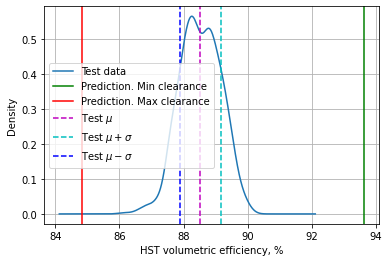

In [7]:
vol_eff.plot(kind='kde',grid=True,label='Test data')
plt.axvline(eff_max['hst']['volumetric'],linestyle='-',label='Prediction. Min clearance',color='g')
plt.axvline(eff_min['hst']['volumetric'],linestyle='-',label='Prediction. Max clearance',color='r')
plt.axvline(vol_eff.mean(),linestyle='--',label='Test $\mu$',color='m')
plt.axvline(vol_eff.mean()+vol_eff.std(),linestyle='--',label='Test $\mu + \sigma$',color='c')
plt.axvline(vol_eff.mean()-vol_eff.std(),linestyle='--',label='Test $\mu - \sigma$',color='b')
plt.xlabel('HST volumetric efficiency, %')
# plt.ylim(0, 100)
plt.legend()

<AxesSubplot:>

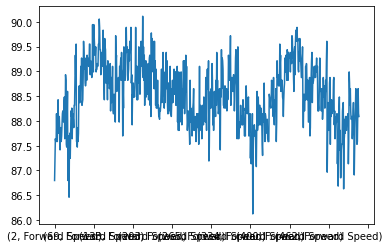

In [11]:
vol_eff.astype(float).plot()